# Exploratory Data Analysis 
Dominick's Orange Juice Sales

Before modeling let's take a dive into the data. The data used in this example is from the University of Chicago's Dominick's Finer Foods dataset to forecast orange juice sales. Dominick's was a grocery chain in the Chicago metropolitan area. 

### Import Packages 

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Read in the Data

The first step is to read in the dataset. We will read the data from a local csv file into a pandas DataFrame. The column _WeekStarting_ is a date field so we want to parse it as a datetime type when we read in the file. 

Each row in the DataFrame holds a quantity of weekly sales for an OJ brand at a single store. The data also includes the sales price, a flag indicating if the OJ brand was advertised in the store that week, and some customer demographic information based on the store location. For historical reasons, the data also include the logarithm of the sales quantity. The Dominick's grocery data is commonly used to illustrate econometric modeling techniques where logarithms of quantities are generally preferred.    

In [5]:
time_column_name = 'WeekStarting'
oj = pd.read_csv("dominicks_OJ.csv", parse_dates=[time_column_name])
oj.head()

,WeekStarting,Store,Brand,Quantity,logQuantity,Advert,Price,Age60,COLLEGE,INCOME,Hincome150,Large HH,Minorities,WorkingWoman,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,1990-06-14,2,dominicks,10560,9.264829,1,1.59,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
1,1990-06-14,2,minute.maid,4480,8.407378,0,3.17,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
2,1990-06-14,2,tropicana,8256,9.018695,0,3.87,0.232865,0.248935,10.553205,0.463887,0.103953,0.114280,0.303585,2.110122,1.142857,1.927280,0.376927
3,1990-06-14,5,dominicks,1792,7.491088,1,1.59,0.117368,0.321226,10.922371,0.535883,0.103092,0.053875,0.410568,3.801998,0.681818,1.600573,0.736307
4,1990-06-14,5,minute.maid,4224,8.348538,0,2.99,0.117368,0.321226,10.922371,0.535883,0.103092,0.053875,0.410568,3.801998,0.681818,1.600573,0.736307


### Data Preperation

We want to create a column called _Revenue_ which is the _Quantity_ times the _Price_. We also will not be using the demographic information for this tutorial so we will subset the dataframe to the desired columns. 

In [10]:
oj['Revenue'] = oj['Quantity'] * oj['Price']
oj = oj[['WeekStarting', 'Store','Brand','Quantity','Revenue', 'Advert']]

#### Check for missing values 

In [17]:
oj.isnull().sum()

WeekStarting    0
Store           0
Brand           0
Quantity        0
Revenue         0
Advert          0
dtype: int64

#### Summary Statistics

In [18]:
oj.describe()

,Store,Quantity,Revenue,Advert
count,28947.000000,28947.000000,28947.000000,28947.000000
mean,80.883511,17312.213355,33066.539737,0.237261
std,35.576511,27477.660437,41861.847391,0.425411
min,2.000000,64.000000,159.360000,0.000000
25%,53.000000,4864.000000,11576.320000,0.000000
50%,86.000000,8384.000000,19537.920000,0.000000
75%,111.000000,17408.000000,36544.640000,0.000000
max,137.000000,716416.000000,999398.400000,1.000000


### Time Series Exploratory Data Analysis

The task is now to build a time-series model for the _Quantity_ column. It is important to note that this dataset is comprised of many individual time-series - one for each unique combination of _Store_ and _Brand_. To distinguish the individual time-series, we thus define the **grain** - the columns whose values determine the boundaries between time-series: 

In [21]:
grain_column_names = ['Store', 'Brand']
nseries = oj.groupby(grain_column_names).ngroups
print('Data contains {0} individual time-series.'.format(nseries))

Data contains 249 individual time-series.


For visualization purposes, we extract sales time-series for just a few of the stores:

In [22]:
use_stores = [2, 5, 8]
data_subset = oj[oj.Store.isin(use_stores)]
nseries = data_subset.groupby(grain_column_names).ngroups
print('Data subset contains {0} individual time-series.'.format(nseries))

Data subset contains 9 individual time-series.


We want to set the _WeekStarting_ column as the index of the dataframe. 

In [23]:
data_subset = data_subset.set_index('WeekStarting')

Next, let's take a look at the individual series. We will plot each of the three stores by Brand. 

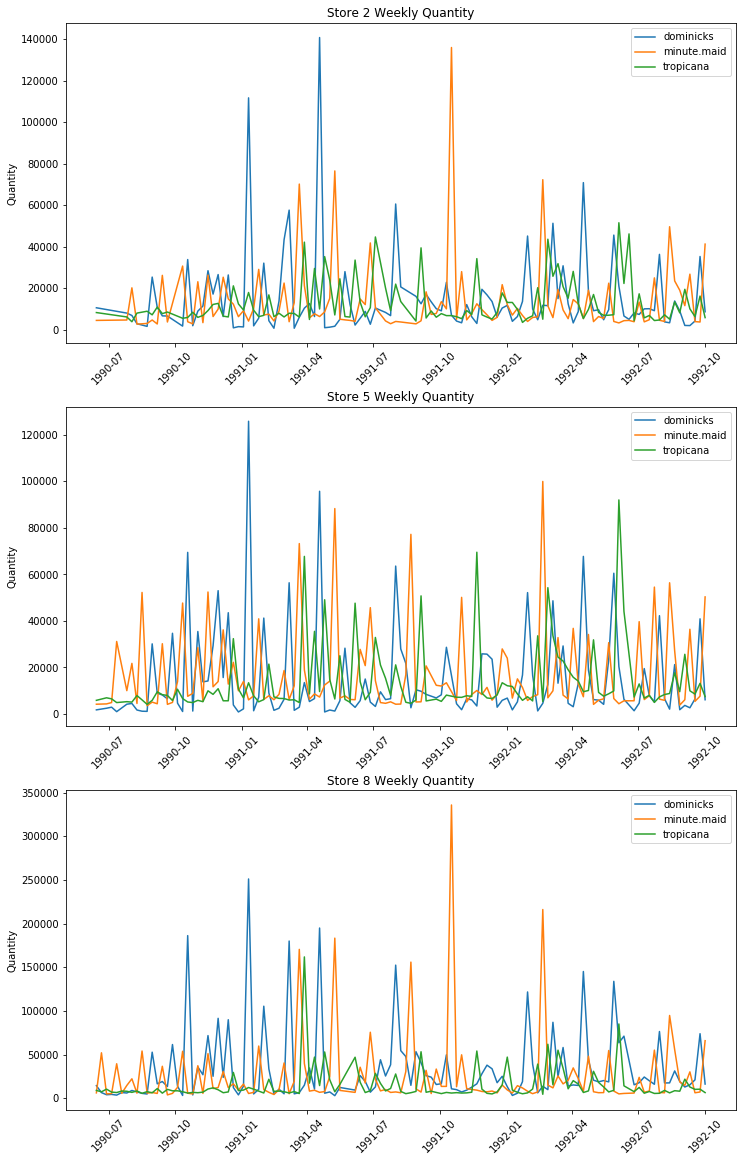

In [27]:
fig, ax = plt.subplots(3, figsize = (12,20))

for i in range(0,len(use_stores)):
    data = data_subset[data_subset['Store'] == use_stores[i]]
    
    plt.subplot(3,1,i+1)
    # add loop to plot each brand  
    for label, grp in data.groupby('Brand'):
        plt.plot(grp.index, grp['Quantity'], label = label)
    plt.legend()
    plt.title("Store {} Weekly Quantity".format(use_stores[i]))
    plt.xticks(rotation = 45)
    plt.ylabel('Quantity')

plt.show()

For time series, we also want to look at the decomposition of a series. The decomposition allows us to break the series down into parts to understand what is contributing to the pattern. The [seasonal_decomposition](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) function breaks the series into the trend, seasonal, and noise components. 

Let's subset to one store and brand for the next plot. 

In [28]:
store5 = data_subset[(data_subset['Store'] == 5) & (data_subset['Brand']== 'tropicana')]

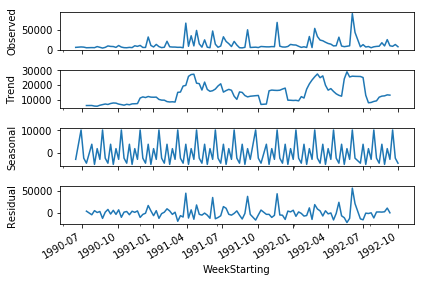

In [35]:
result = seasonal_decompose(store5['Quantity'], freq = 7 )
decomposition = result.plot()

This series has a seasonal component, possibly at the month level since the data is at the weekly interval. There isn't a constant trend for the series. 

For ARIMA time series modeling the Auto-correlation (ACF) and Partial Auto-correlation (PACF) plots can help to determine the auto-regressive (AR) and moving average (MA) terms. The p and q terms in ARIMA(p,d,q). The ACF plot gives the value of a series auto-correlation with its lagged values. The PACF plot is similar to the ACF, but it finds the correlation with the next lagged value. 

In the plots, we want to look for any residuals that are outside of the confidence band (the blue area). If you see a pattern in the plots, this may indicate a seasonal pattern in the series. 

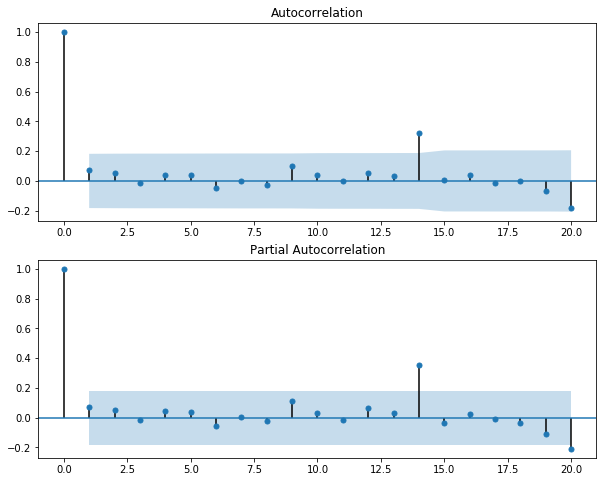

In [38]:
fig, ax = plt.subplots(2, figsize=(10,8))
ax[0] = plot_acf(store5['Quantity'], ax=ax[0], lags = 20)
ax[1] = plot_pacf(store5['Quantity'], ax=ax[1], lags = 20)
plt.show()